## はじめる前に

### 注意すべきバイアス

・Curve Fitting  
OHLCデータの特定の特性に合わせて戦略を過度に調整しすぎた結果、過去のデータではうまくいくが未来の未知のデータでは機能しない状況。

## 初期設定

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

# データ読み込み
df = pd.read_csv("btc_jpy-1min-20250501_20251101.csv", index_col=0, parse_dates=True)

## シグナル生成

In [ ]:
# ===============
# 戦略
# SMA_longとSMA_shortの位置関係でトレンドを判断し、SMA_signalがSMA_shortを上抜け/下抜けしたら売買シグナルを出す
# 決済はトリプルバリアを用いる
# ===============
# 単純移動平均(SMA)
def SMA(data,term):
  weight = np.ones(term)
  res = np.zeros(len(data)-term)
  for i in range(len(data)-term):
    res[i] = (data[i:i+term]*weight).sum()/weight.sum()
  return np.concatenate([np.zeros(term),res])

# トリプルバリアの決済逆算関数
def triple_barrier_exit(close, high, low, upper_rate, lower_rate, holding_period):
    n = len(close)
    diff = np.zeros(n)
    hold_times = np.full((n,), holding_period)
    exit_times = np.arange(n-1)
    for start_idx in range(n-holding_period):
        offset_high = high[start_idx:start_idx+holding_period]
        offset_low = low[start_idx:start_idx+holding_period]
        res = np.where(offset_high/close[start_idx] >= upper_rate, 1,np.where(offset_low/close[start_idx] <= lower_rate, -1, 0))
        hit_indices = np.nonzero(res)[0]
        if len(hit_indices) > 0:
            hold_times[start_idx] = hit_indices[0].item() + 1
            exit_times[start_idx] = start_idx + hit_indices[0].item()
            if res[hit_indices[0]] == 1:
                diff[start_idx] = upper_rate-1
            elif res[hit_indices[0]] == -1:
                diff[start_idx] = lower_rate-1
        else:
            hold_times[start_idx] = holding_period
            exit_times[start_idx] = min(start_idx + holding_period - 1, n - 1)
            diff[start_idx] = (close[exit_times[start_idx]] - close[start_idx]) / close[start_idx]
    return diff, hold_times, exit_times



# torchテンソル化
fre1_close_tensor = df["close"].to_numpy()
fre1_high_tensor = df['high'].to_numpy()
fre1_low_tensor = df['low'].to_numpy()

# パラメーター
long_term = 120
short_term = 60
signal_term = 30
upper_rate = 1.01
lower_rate = 0.99
holding_period = 180

# 新規注文シグナル生成
sma_long = SMA(fre1_close_tensor, long_term)
sma_short = SMA(fre1_close_tensor, short_term)
sma_signal = SMA(fre1_close_tensor, signal_term)
open = np.where((sma_signal > sma_short), 1, -1) # signalとshortの位置関係を抽出
buy_open = np.concatenate([np.zeros(1), np.where((sma_short > sma_long)[1:] & (open[:-1] != 1) & (open[1:] == 1), 1, 0)]) # shortがlongより高い(上昇トレンド)さらにsignalがshortを上抜けた(openが1に変わった)時に買い建て新規注文
sell_open = np.concatenate([np.zeros(1), np.where((sma_short < sma_long)[1:] & (open[:-1] != -1) & (open[1:] == -1), -1, 0)]) # shortがlongより低い(下降トレンド)さらにsignalがshortを下抜けた(openが-1に変わった)時に売り建て新規注文

# 逆算決済シグナル生成
slippage = 0.001
diff, hold_times, close_times = triple_barrier_exit(fre1_close_tensor, fre1_high_tensor, fre1_low_tensor, upper_rate, lower_rate, holding_period)
long_gains = np.where(diff > slippage, diff, 0)
loss = np.where((diff < slippage) & (diff > -slippage), diff, 0)
short_gains = np.where(diff < -slippage, diff, 0)

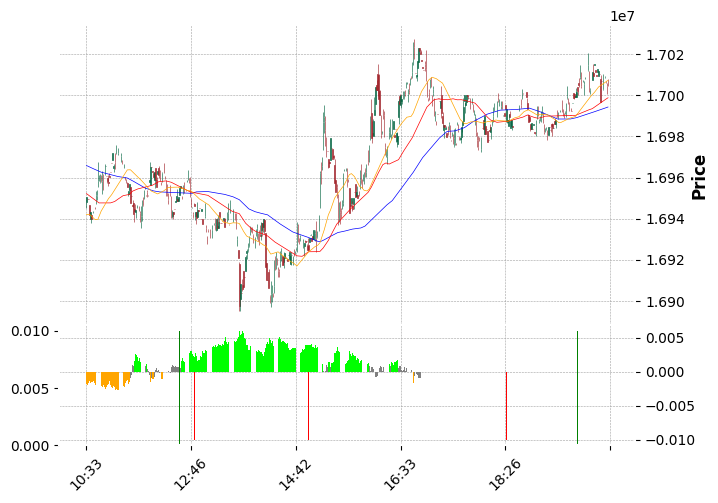

In [62]:
# 表示 ===============
# シグナル表示
# ===============
start_term = -500
end_term = -1

df["SMA_long"] = sma_long
df["SMA_short"] = sma_short
df["SMA_signal"] = sma_signal
df["buy_open"] = buy_open*(upper_rate-1)
df["sell_open"] = sell_open*(1-lower_rate)
df["long_gains"] = long_gains
df["loss"] = loss
df["short_gains"] = short_gains

add_plots = [
    mpf.make_addplot(df["SMA_long"][start_term:end_term], panel=0, color='blue', width=0.5),
    mpf.make_addplot(df["SMA_short"][start_term:end_term], panel=0, color='red', width=0.5),
    mpf.make_addplot(df["SMA_signal"][start_term:end_term], panel=0, color='orange', width=0.5),
    mpf.make_addplot(df["long_gains"][start_term:end_term], panel=1, type='bar', color='lime'),
    mpf.make_addplot(df["loss"][start_term:end_term], panel=1, type='bar', color='gray'),
    mpf.make_addplot(df["short_gains"][start_term:end_term], panel=1, type='bar', color='orange'),
    mpf.make_addplot(df["buy_open"][start_term:end_term], panel=1, type='bar', color='green'),
    mpf.make_addplot(df["sell_open"][start_term:end_term], panel=1, type='bar', color='red'),
]

mpf.plot(
    df[start_term:end_term],
    addplot=add_plots,
    type='candle',
    volume=False,
    style='charles',
    figsize=(8,6)
)

## バックテスト

シャープレシオ: -0.1532267383377965
平均期待リターン: -0.000894417360459009
1日あたりの往復回数: 4.523659150747628


<Axes: xlabel='openTime'>

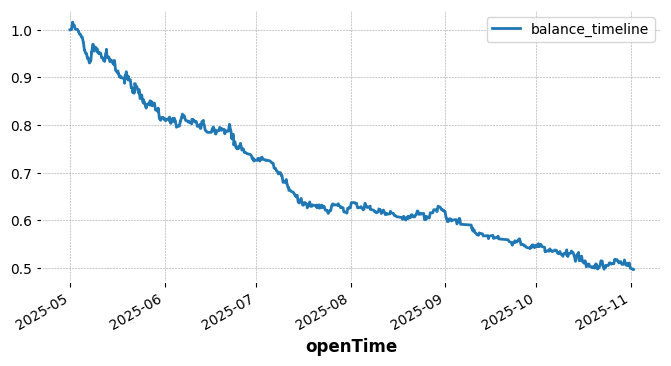

In [63]:
def backtest(pos, open_times, diff, close_times, slippage=0.001, fee=0, levarage=1):
    balance_timeline = np.ones(len(pos))
    return_rations = []
    i = open_times[0]
    while i < len(open_times):
        return_ration = (diff[i]*pos[i]-slippage)*levarage*(1-fee)
        balance_timeline[close_times[i]:] = balance_timeline[i]*(1+return_ration)
        return_rations.append(return_ration)
        i = close_times[i]+1
        i = open_times[i]
    return_rations = np.array(return_rations)
    sharpe_ratio = return_rations.mean()/return_rations.std()
    daily_trips = 1440/(len(pos)/len(return_rations))
    return balance_timeline, sharpe_ratio, return_rations.mean(), daily_trips

pos = buy_open + sell_open
open_times = np.zeros(len(pos), dtype=np.long)
for i in range(len(pos)-1,-1,-1):
    if pos[i] != 0:
        open_times[i] = i
    else:
        open_times[i] = open_times[i+1] if i+1 < len(pos) else len(open_times)
balance_timeline, sharpe_ratio, daily_return, daily_trips = backtest(pos, open_times, diff, close_times)
print("シャープレシオ:", sharpe_ratio.item())
print("平均期待リターン:", daily_return.item())
print("1日あたりの往復回数:", daily_trips)
# ===============
# 資産推移
# =============== 
df["balance_timeline"] = balance_timeline
df[["balance_timeline"]].plot(figsize=(8,4))

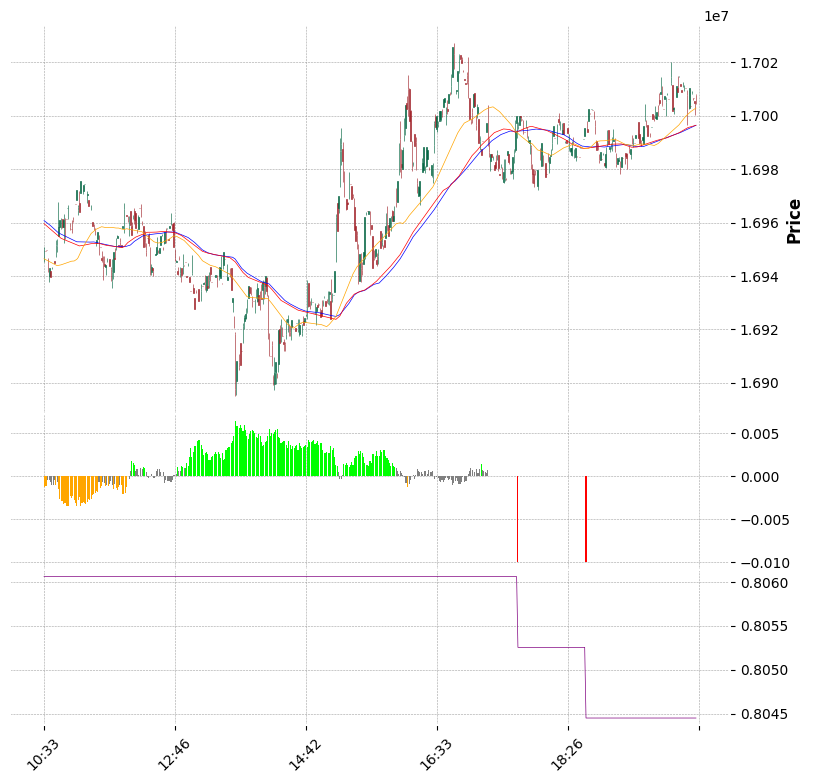

In [20]:
# 表示 ===============
#
# ===============
start_term = -500
end_term = -1

df["SMA_long"] = sma_long
df["SMA_short"] = sma_short
df["SMA_signal"] = sma_signal
df["buy_open"] = buy_open*(upper_rate-1)
df["sell_open"] = sell_open*(1-lower_rate)
df["long_gains"] = long_gains
df["loss"] = loss
df["short_gains"] = short_gains
df["balance_timeline"] = balance_timeline

add_plots = [
    mpf.make_addplot(df["SMA_long"][start_term:end_term], panel=0, color='blue', width=0.5),
    mpf.make_addplot(df["SMA_short"][start_term:end_term], panel=0, color='red', width=0.5),
    mpf.make_addplot(df["SMA_signal"][start_term:end_term], panel=0, color='orange', width=0.5),
    mpf.make_addplot(df["long_gains"][start_term:end_term], panel=1, type='bar', color='lime'),
    mpf.make_addplot(df["loss"][start_term:end_term], panel=1, type='bar', color='gray'),
    mpf.make_addplot(df["short_gains"][start_term:end_term], panel=1, type='bar', color='orange'),
    mpf.make_addplot(df["buy_open"][start_term:end_term], panel=1, type='bar', color='green'),
    mpf.make_addplot(df["sell_open"][start_term:end_term], panel=1, type='bar', color='red'),
    mpf.make_addplot(df["balance_timeline"][start_term:end_term], panel=2, color='purple', width=0.5)
]

mpf.plot(
    df[start_term:end_term],
    addplot=add_plots,
    type='candle',
    volume=False,
    style='charles',
    figsize=(10,10)
)